# Stereo Fisheye Camera Calibration


### Setup


In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob


In [ ]:
# termination criteria
subpix_criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.0001)
corners_criteria = cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_NORMALIZE_IMAGE

nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny, 1, 3), np.float32)
objp[:, 0, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints_left = [] # 2d points in image plane.
imgpoints_right = []
images_left = sorted(glob.glob('../assets/sample_images/left_*.jpg'))
images_right = sorted(glob.glob('../assets/sample_images/right_*.jpg'))


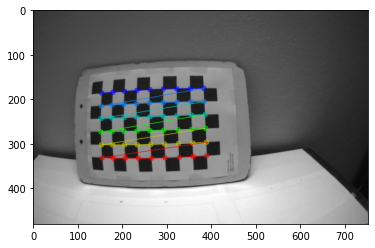

In [ ]:
for fname in images_left:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (nx, ny), corners_criteria)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        win_size = (3, 3) # Change 'win_size' for accuracy. Default is (11,11).
        corners = cv.cornerSubPix(gray,corners, win_size, (-1, -1), subpix_criteria)
        imgpoints_left.append(corners)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

for fname in images_right:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (nx,ny), corners_criteria)

    # If found, add object points, image points (after refining them)
    if ret == True:

        win_size = (3, 3) # Change 'win_size' for accuracy. Default is (11,11).
        corners = cv.cornerSubPix(gray,corners, win_size, (-1, -1), subpix_criteria)
        imgpoints_right.append(corners)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)
        

Make sure if length of objpoints = length of  imgpoints_left = length of imgpoints_right


In [ ]:
print("Length of objpoints = ", len(objpoints))
print("Length of imgpoints_left = ", len(imgpoints_left))
print("Length of imgpoints_right = ", len(imgpoints_right))


Length of objpoints =  20
Length of imgpoints_left =  20
Length of imgpoints_right =  20


### Calibrate


In [ ]:
N_OK = len(objpoints)
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
calibration_flags = cv.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv.fisheye.CALIB_CHECK_COND + cv.fisheye.CALIB_FIX_SKEW
calibration_criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
mtx_left = np.zeros((3, 3))
dist_left = np.zeros((4, 1))
rms_left, _, _, _, _ = cv.fisheye.calibrate(objpoints, imgpoints_left, gray.shape[::-1], mtx_left, dist_left, rvecs, tvecs, calibration_flags, calibration_criteria)


rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
mtx_right = np.zeros((3, 3))
dist_right = np.zeros((4, 1))
rms_right, _, _, _, _ = cv.fisheye.calibrate(objpoints, imgpoints_right, gray.shape[::-1], mtx_right, dist_right, rvecs, tvecs, calibration_flags, calibration_criteria)


calibration_flags = cv.fisheye.CALIB_FIX_INTRINSIC
rvecs = np.zeros((1, 1, 3), dtype=np.float64)
tvecs = np.zeros((1, 1, 3), dtype=np.float64)
objpoints = np.array(objpoints, dtype=np.float64)
imgpoints_left = np.array(imgpoints_left, dtype=np.float64)
imgpoints_right = np.array(imgpoints_right, dtype=np.float64)
rms, _, _, _, _, _, _ = cv.fisheye.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx_left, dist_left, mtx_right, dist_right, gray.shape[::-1], rvecs, tvecs, calibration_flags, calibration_criteria)


In [ ]:
print("Left RMS = ", rms_left)
print("Right RMS = ", rms_right)
print("RMS = ", rms)


Left RMS =  0.14677471138377596
Right RMS =  0.12902913880640937
RMS =  0.1568571977381319


In [ ]:
img = cv.imread('../assets/sample_imagesleft_1.jpg')

map1, map2 = cv.fisheye.initUndistortRectifyMap(mtx_left, dist_left, np.eye(3), mtx_left, gray.shape[::-1], cv.CV_16SC2)
undistorted_left = cv.remap(img, map1, map2, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)


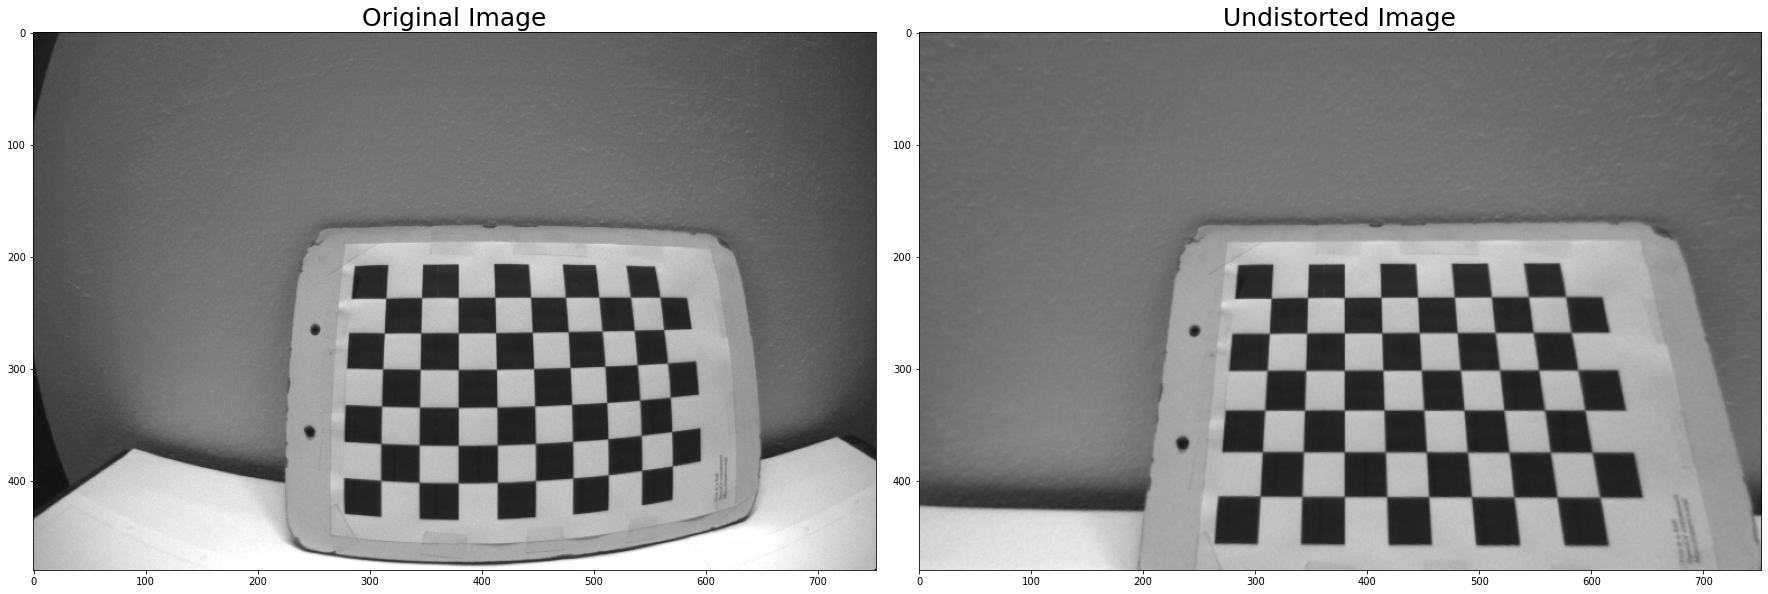

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 25)
ax2.imshow(undistorted_left)
ax2.set_title('Undistorted Image', fontsize = 25)
plt.subplots_adjust(left = 0., right = 1, top = 0.9, bottom = 0.)


In [ ]:
img = cv.imread('../assets/sample_images/right_1.jpg')

map1, map2 = cv.fisheye.initUndistortRectifyMap(mtx_right, dist_right, np.eye(3), mtx_left, gray.shape[::-1], cv.CV_16SC2)
undistorted_right = cv.remap(img, map1, map2, interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT)


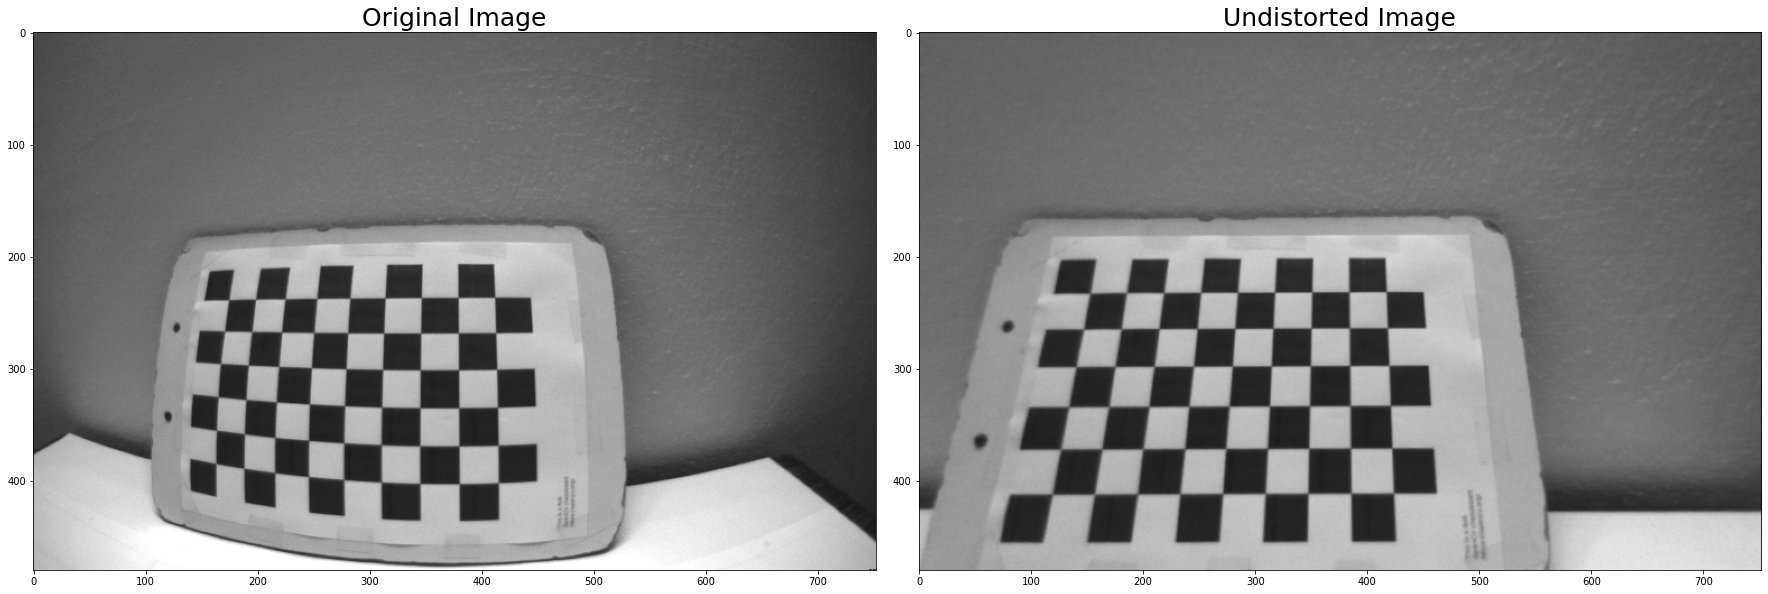

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 25)
ax2.imshow(undistorted_right)
ax2.set_title('Undistorted Image', fontsize = 25)
plt.subplots_adjust(left = 0., right = 1, top = 0.9, bottom = 0.)


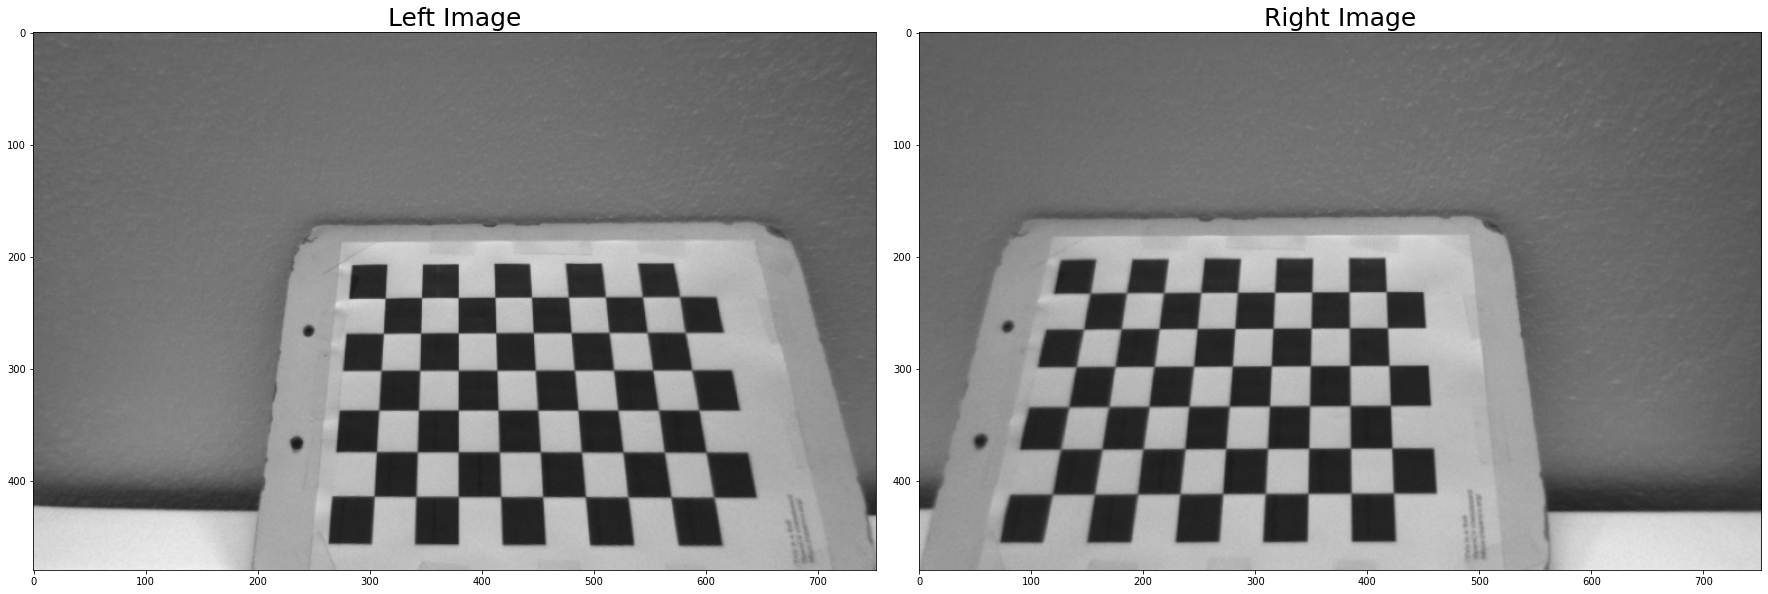

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_left)
ax1.set_title('Left Image', fontsize = 25)
ax2.imshow(undistorted_right)
ax2.set_title('Right Image', fontsize = 25)
plt.subplots_adjust(left = 0., right = 1, top = 0.9, bottom = 0.)
